In [3]:
import numpy as np
import scipy
import sympy as sy
from sympy import *
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
#inclination of the container, rad
theta = 0.15

#refraction coefficients, pure number
n_a = 1
n_g = 1.5 * n_a
n_l = 1.4 * n_a

#speed of light, m/s
c = 3 * 10**8

#internal width of the container, m
d = 10 * 10**(-2)

#glass width, m
delta = 5* 10**(-3)

#angle between the laser beams which impact the container, rad
phi = 10**(-5)

#wavelength of laser, m
wavelength = 8*10**(-7)

#angle sensibility
delta_theta = 1* 10**(-5)
delta_theta_deg = np.rad2deg(delta_theta)

#array of plausible angles
max_theta_deg = 15
max_theta = np.deg2rad(max_theta_deg)
N = 1000
theta_array = np.array(range(N)) / N * max_theta

#array of indices of refraction
n_l_min = 1.4
n_l_max = 1.5
N = 1000
n_l_array = np.array(range(N)) / N * (n_l_max - n_l_min) + n_l_min

In [5]:
def difference_optical_path_nophi(theta, n_l, d):
    '''In the approximation of parallel laser beams,
    difference in c*time between the laser beams.
    The path difference between the arms is ignored.
    '''
    
    cdeltat = ( d * ((n_l /(np.sqrt(1 - (np.sin(theta) / n_l)**2))) 
                + np.sin(theta) * (np.tan(theta) - 1/(np.sqrt((n_l/np.sin(theta))**2 -1)))
                - 1 / np.cos(theta))
              )
    
    return(cdeltat)


def difference_optical_path_yesphi(theta, phi, n_g, n_l, d, delta):
    '''Difference in optical path taking into account an angle phi between the two laser beams
    before encountering the container.'''
   
    theta_prime = theta + phi    

    '''Auxilliary functions follow'''
    def length_path_air(theta, d, delta, n_l, n_g):
    
        h_g = 2 * delta / np.sqrt((n_g / np.sin(theta))**2 - 1)
        h_l = d / np.sqrt((n_l / np.sin(theta))**2 - 1)

        length_path_air = (np.sin(theta) * ((d + 2 * delta) * np.tan(theta) - h_g - h_l) 
                           - (d + 2 * delta) / np.cos(theta))

        return(length_path_air)

    def length_path_glass(theta, d, delta, n_g):

        length_path_glass = 2 * delta / np.sqrt(1 - (np.sin(theta) / n_g)**2)

        return(length_path_glass)

    def length_path_liquid(theta, d, delta, n_l):
        length_path_liquid = d / np.sqrt(1 - (np.sin(theta) / n_l)**2)
        return(length_path_liquid)

    def total_path_length(theta, d, delta, n_g, n_l):
        total_path_length = (length_path_air(theta, d, delta, n_l, n_g) 
                             + n_g * length_path_glass(theta, d, delta, n_g) 
                             + n_l * length_path_liquid(theta, d, delta, n_l))
        return(total_path_length)
    
    cdeltat = total_path_length(theta, d, delta, n_g, n_l) - total_path_length(theta_prime, d, delta, n_g, 1)

    return(cdeltat)
    

def n_fringes(wavelength, theta, n_l, d):
    '''Number of fringes we see between theta=0 and the angle given.'''
    
    n_fringes = (2 / wavelength * (difference_optical_path_nophi(theta, n_l, d)
                                 - difference_optical_path_nophi(0, n_l, d)))
    
    return(n_fringes)

def n_fringes_yesphi(wavelength, theta, n_l, n_g, d, delta, phi):
    '''Number of fringes we see between theta=0 and the angle given, considering phi.'''
    
    n_fringes = (2 / wavelength * (difference_optical_path_yesphi(theta, phi, n_g, n_l, d, delta)
                                 - difference_optical_path_yesphi(0, phi, n_g, n_l, d, delta)))
    
    return(n_fringes)


def epsilon(theta, n_l, n_g, d, delta):
    '''Displacement of the laser beam in the perpendicular direction
    corresponding to an angle theta, relative to theta = 0.'''
    
    epsilon = (np.cos(theta) * (d * (np.tan(theta) - 1/ np.sqrt((n_l/np.sin(theta))**2 -1)) 
                                + 2 * delta * (np.tan(theta) - 1/ np.sqrt((n_g/np.sin(theta))**2 -1))))
    
    return(epsilon)

def deltaN(theta, delta_theta, wavelength, n_l, d):
    '''Resolution at angle theta, corresponding to an angular resolution of delta_theta:
    how many fringes do we see between theta and theta+delta_theta?'''
    
    theta1 = theta
    theta2 = theta+delta_theta
    deltaN = (n_fringes(wavelength, theta2, n_l, d) 
                - n_fringes(wavelength, theta1, n_l, d))
    return(deltaN)

In [6]:
print(difference_optical_path_nophi(theta=theta, d=d, n_l=n_l), ', ',
difference_optical_path_yesphi(theta=theta, d=d, delta= delta, n_l=n_l, n_g= n_g, phi=0.04))

0.04032304466905661 ,  0.040300118652505754


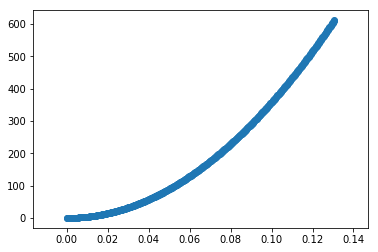

In [5]:
#for better resolution on the first points, set first_fringes to something less than N
first_fringes = 500
plt.scatter(theta_array[0:first_fringes],
            n_fringes(wavelength, theta_array, n_l, d)[0:first_fringes])

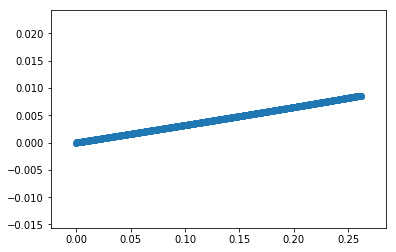

In [7]:
plt.scatter(theta_array, np.array(epsilon(theta_array, n_l, n_g, d, delta)))

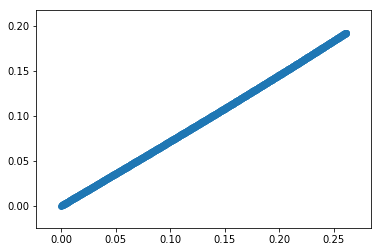

In [8]:
plt.scatter(theta_array,  deltaN(theta_array, delta_theta, wavelength, n_l, d))

In [78]:
n_l_base = 1.4
n_fringes_base = n_fringes(wavelength, theta, n_l_base, d)

step = 0.0001
n_fringes_current = n_fringes_base

n_l = n_l_base
while(n_fringes_current < n_fringes_base + 1):
    n_l = n_l + step
    n_fringes_current = n_fringes(wavelength, theta, n_l, d)

print("Change in n_l corresponding to 1 fringe of displacement, no phi")
print(n_l - n_l_base)

phi_primes = 20
phi_deg = phi_primes / 60
phi =  np.deg2rad(phi_deg)
n_l = 1.4

print("Difference in number of fringes between phi = 0 and the value given")
print(n_fringes_yesphi(wavelength, theta, n_l, n_g, d, delta, phi) - n_fringes_yesphi(wavelength, theta, n_l, n_g, d, delta, 0))

Variazione di n_l corrispondente a 1 frangia di spostamento, no phi
0.0006999999999999229
frange che cambiano con phi
-7.339855347468529


**We set**

* $\theta _{max}$: the maximum inclination of the container
* $d$: the width of the container
* $n_l$: the approximate value of the index of refraction of the liquid

**We calculate**

* $\varepsilon _{max}$: the displacement in the perpendicular direction
* $N_{fr}$: number of fringes between 0 and $\theta_{max}$
* $\Delta_n$: fringes resolution at $\theta_{max}$
* $\chi = \Delta _{n_l}$ corresponding to $\Delta_n = 1$

In [76]:
step = 0.000001
n_l_current = n_l
n_fringes_base = n_fringes(wavelength, theta, n_l, d)
n_fringes_current = n_fringes_base
while(n_fringes_current < n_fringes_base + 1):
    n_l_current = n_l_current + step
    n_fringes_current = n_fringes(wavelength, theta, n_l_current, d)
    #print("Hey jude")
    
chi = n_l_current - n_l

print("Epsilon = ", epsilon(theta, n_l, n_g, d, delta) * 10**3)
print("n_fringes = ", n_fringes(wavelength, theta, n_l, d))
print("delta_n = ", deltaN(theta, delta_theta, wavelength, n_l, d))
print("chi = ", chi * 10**4)

Epsilon =  4.8332636902862784
n_frange =  807.6116726415429
delta_n =  1.082586700718707
chi =  6.9699999994266015
